In [33]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# ---------------------------------------------
# 1. Load Dataset
# ---------------------------------------------
df = pd.read_csv("fuzzy_students_120.csv")
print(" Dataset loaded successfully! Sample:")
print(df.head(), "\n")

 Dataset loaded successfully! Sample:
   student_id  study_hours  sleep_hours  score
0           1         6.30         6.28   56.4
1           2         3.79         6.64   41.8
2           3         6.94         4.98   53.5
3           4         5.73         5.90   53.8
4           5         1.21         5.33   22.0 



In [34]:
# Use three features
data = df[['study_hours', 'sleep_hours', 'score']].to_numpy().T  # shape (features, samples)
n_points = data.shape[1]
print(f"Data shape for clustering: {data.shape} ({n_points} students)")

Data shape for clustering: (3, 120) (120 students)


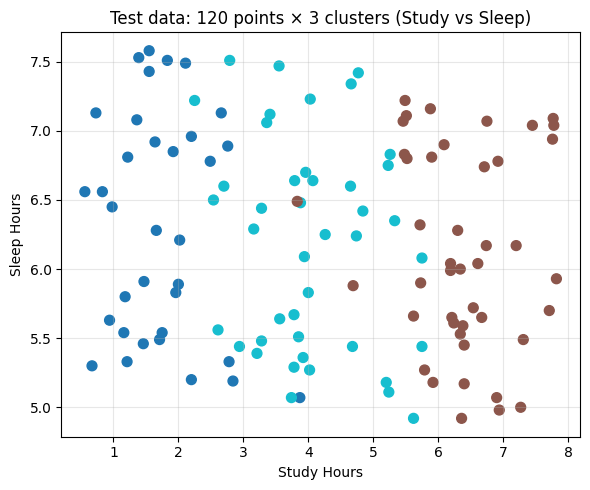

In [35]:
# ---------------------------------------------
# 2. Visualize Raw Data (2D projection)
# ---------------------------------------------
plt.figure(figsize=(6, 5))
plt.scatter(df['study_hours'], df['sleep_hours'], c=cluster_membership, cmap='tab10', s=50)
plt.title(f'Test data: {n_points} points × 3 clusters (Study vs Sleep)')
plt.xlabel('Study Hours')
plt.ylabel('Sleep Hours')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


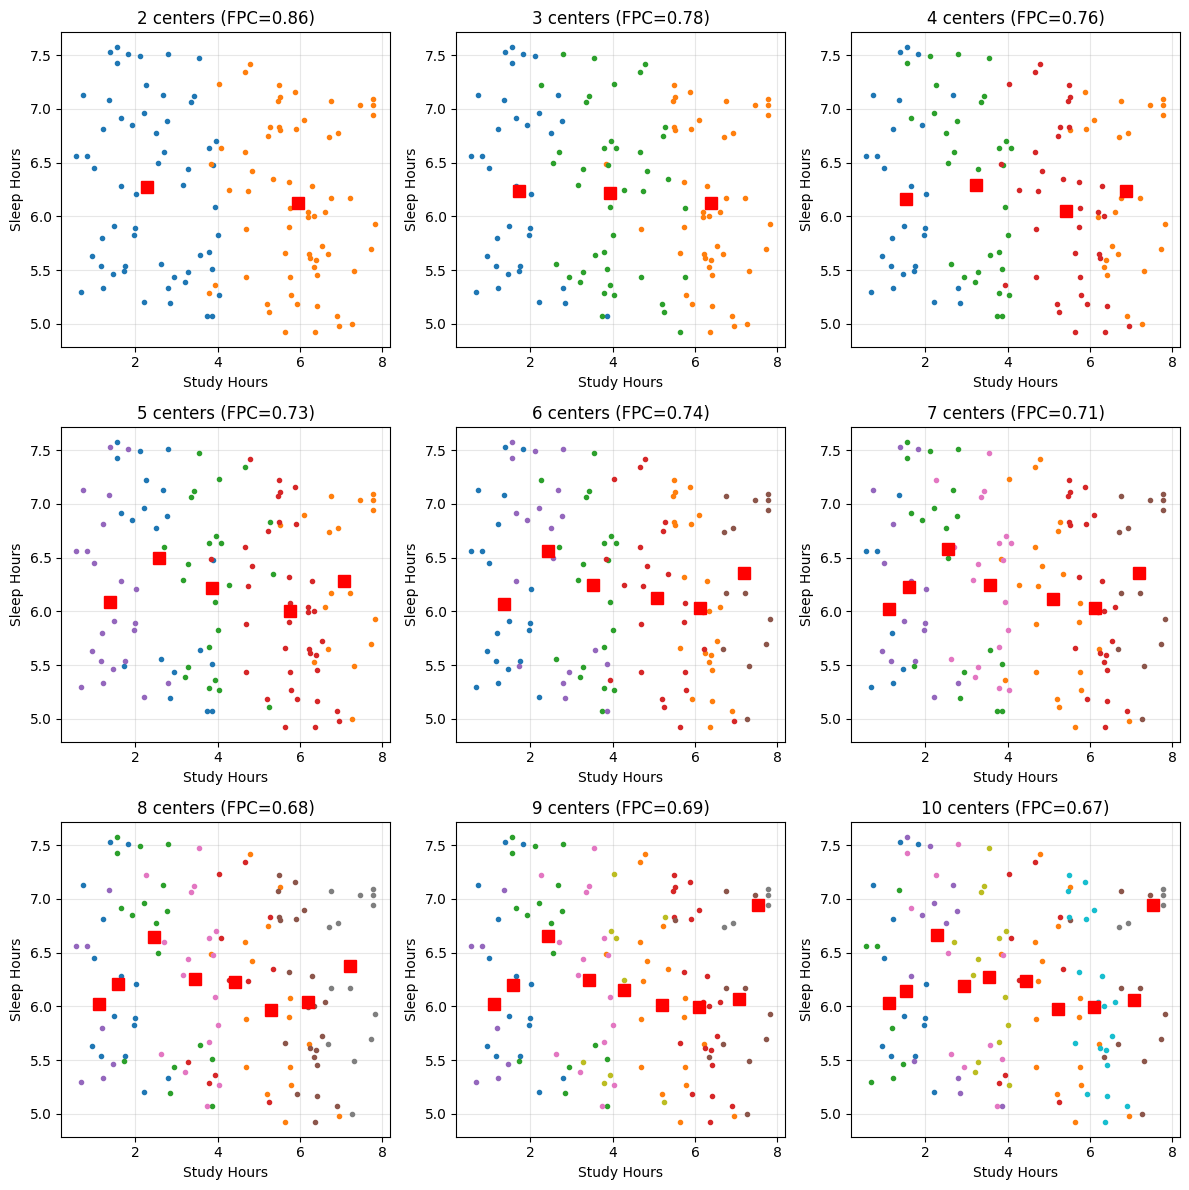

In [36]:
# ---------------------------------------------
# 3. Run clustering for 2–10 clusters
# ---------------------------------------------
fpcs = []
cluster_range = np.arange(2, 11, 1)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for ncenters, ax in zip(cluster_range, axes):
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        data=data,
        c=ncenters,
        m=2.0,
        error=0.005,
        maxiter=1000,
        init=None,
        seed=42
    )
    fpcs.append(fpc)

    # Hard partition for visualization (based on first 2 features)
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(
            df['study_hours'][cluster_membership == j],
            df['sleep_hours'][cluster_membership == j],
            '.', label=f'cluster {j+1}'
        )
    ax.plot(cntr[:, 0], cntr[:, 1], 'rs', markersize=8)
    ax.set_title(f'{ncenters} centers (FPC={fpc:.2f})')
    ax.set_xlabel('Study Hours')
    ax.set_ylabel('Sleep Hours')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

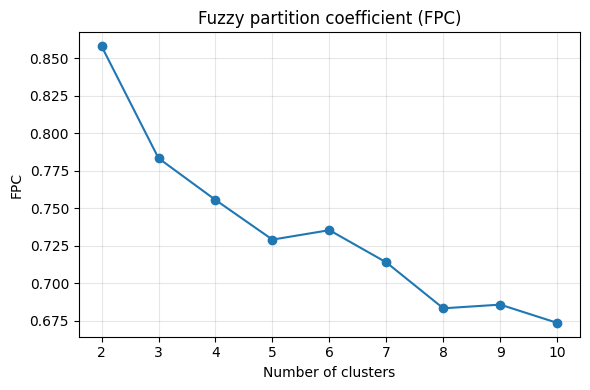

In [37]:
plt.figure(figsize=(6, 4))
plt.plot(cluster_range, fpcs, marker='o')
plt.title('Fuzzy partition coefficient (FPC)')
plt.xlabel('Number of clusters')
plt.ylabel('FPC')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [38]:
# ---------------------------------------------
# 5. Train Final Model (3 clusters)
# ---------------------------------------------
ncenters = 3
cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
    data=data,
    c=ncenters,
    m=2.0,
    error=0.005,
    maxiter=1000,
    init=None,
    seed=42
)
cluster_membership = np.argmax(u, axis=0)
print(f"Final model trained with {ncenters} clusters (FPC={fpc:.3f})")

Final model trained with 3 clusters (FPC=0.783)


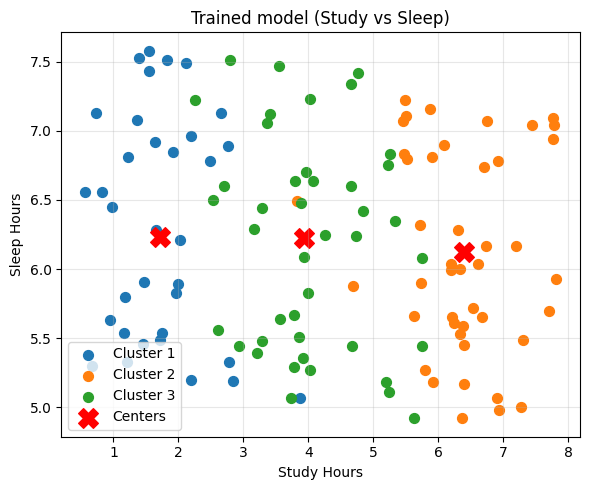

 Fig3 (2D): Trained model saved as Fig3_TrainedModel_2D.png


In [39]:
plt.figure(figsize=(6, 5))
for j in range(ncenters):
    plt.scatter(
        df['study_hours'][cluster_membership == j],
        df['sleep_hours'][cluster_membership == j],
        s=50, label=f'Cluster {j+1}'
    )
plt.scatter(cntr[:, 0], cntr[:, 1], marker='X', s=200, c='red', label='Centers')
plt.title('Trained model (Study vs Sleep)')
plt.xlabel('Study Hours')
plt.ylabel('Sleep Hours')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("Fig3_TrainedModel_2D.png", dpi=150, bbox_inches='tight')
plt.show()
print(" Fig3 (2D): Trained model saved as Fig3_TrainedModel_2D.png")

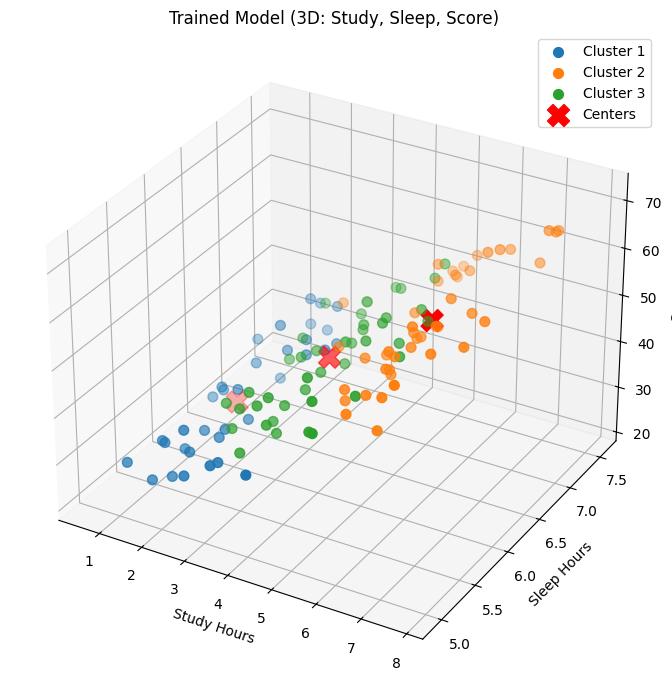

Fig3 (3D): Trained model saved as Fig3_TrainedModel_3D.png


In [40]:
# ---------------------------------------------
# 7. Visualize Final Model (3D: Study, Sleep, Score)
# ---------------------------------------------
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

for j in range(ncenters):
    ax.scatter(
        df['study_hours'][cluster_membership == j],
        df['sleep_hours'][cluster_membership == j],
        df['score'][cluster_membership == j],
        s=50, label=f'Cluster {j+1}'
    )
ax.scatter(
    cntr[:, 0], cntr[:, 1], cntr[:, 2],
    marker='X', s=250, c='red', label='Centers'
)
ax.set_xlabel('Study Hours')
ax.set_ylabel('Sleep Hours')
ax.set_zlabel('Score')
ax.set_title('Trained Model (3D: Study, Sleep, Score)')
ax.legend()
plt.tight_layout()
plt.savefig("Fig3_TrainedModel_3D.png", dpi=150, bbox_inches='tight')
plt.show()
print("Fig3 (3D): Trained model saved as Fig3_TrainedModel_3D.png")

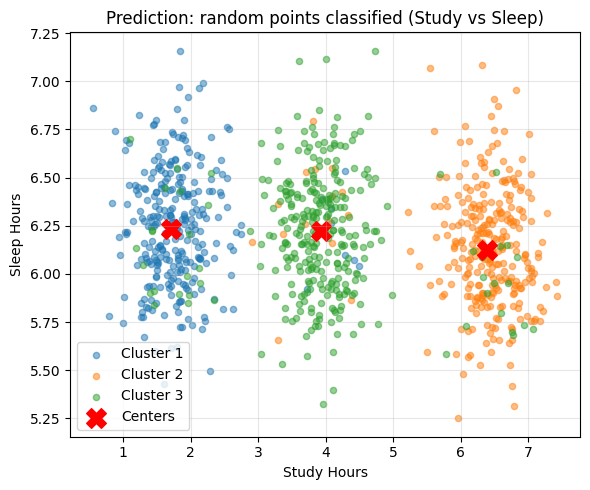

Fig4: Random prediction plot saved as Fig4_PredictedRandomPoints.png


In [41]:
# ---------------------------------------------
# 8. Predict Random New Points
# ---------------------------------------------
new_points = []
for c in cntr:
    noise = np.random.normal(loc=c, scale=[0.4, 0.3, 5], size=(300, 3))
    new_points.append(noise)
new_points = np.vstack(new_points).T

u_pred, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
    test_data=new_points,
    cntr_trained=cntr,
    m=2.0,
    error=0.005,
    maxiter=1000
)
cluster_pred = np.argmax(u_pred, axis=0)

# 2D projection of predicted points
plt.figure(figsize=(6, 5))
for j in range(ncenters):
    plt.scatter(
        new_points[0][cluster_pred == j],
        new_points[1][cluster_pred == j],
        s=20, alpha=0.5, label=f'Cluster {j+1}'
    )
plt.scatter(cntr[:, 0], cntr[:, 1], marker='X', s=200, c='red', label='Centers')
plt.title('Prediction: random points classified (Study vs Sleep)')
plt.xlabel('Study Hours')
plt.ylabel('Sleep Hours')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("Fig4_PredictedRandomPoints.png", dpi=150, bbox_inches='tight')
plt.show()
print("Fig4: Random prediction plot saved as Fig4_PredictedRandomPoints.png")